In [0]:
import pandas as pd
from sklearn.datasets import load_iris
from pyspark.sql import SparkSession

df_iris = load_iris(as_frame=True)

pd_df_iris = pd.DataFrame(df_iris.data, columns = df_iris.feature_names)
pd_df_iris['target'] = pd.Series(df_iris.target)

spark_df_iris = spark.createDataFrame(pd_df_iris)
spark_df_iris = spark_df_iris.drop("target")

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

assemble=VectorAssembler(inputCols=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'],outputCol = 'iris_features')

assembled_data=assemble.transform(spark_df_iris)

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='iris_features', metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='iris_features', k=K)

    KMeans_fit=KMeans_.fit(assembled_data)

    KMeans_transform=KMeans_fit.transform(assembled_data) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)


In [0]:
KMeans_=KMeans(featuresCol='iris_features', k=3) 
KMeans_Model=KMeans_.fit(assembled_data)
KMeans_Assignments=KMeans_Model.transform(assembled_data)

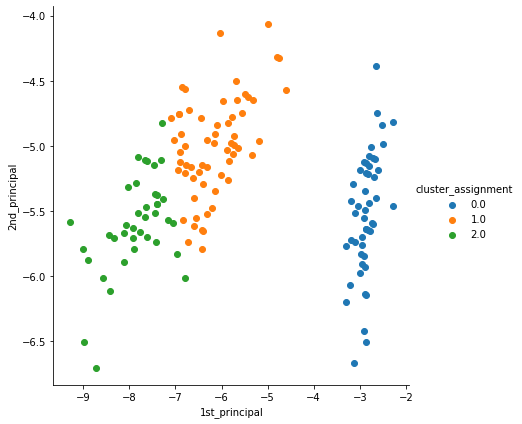

In [0]:
from pyspark.ml.feature import PCA as PCAml
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCAml(k=2, inputCol="iris_features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

pca_data = np.hstack((x_pca, cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()

In [0]:
print("각 군집의 centroid")
print(KMeans_Model.clusterCenters())

각 군집의 centroid
[array([5.006, 3.428, 1.462, 0.246]), array([5.88360656, 2.74098361, 4.38852459, 1.43442623]), array([6.85384615, 3.07692308, 5.71538462, 2.05384615])]


In [0]:
import pyspark
from pyspark.sql import SparkSession

centroid = SparkSession.builder.appName('CENTROID').getOrCreate()

centroidData = [(5.006, 3.428, 1.462, 0.246), (5.88360656, 2.74098361, 4.38852459, 1.43442623), (6.85384615, 3.07692308, 5.71538462, 2.05384615)]

centroidColumns = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
centroidDF = spark.createDataFrame(data = centroidData, schema = centroidColumns)

centroidAssemble=VectorAssembler(inputCols=['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'], outputCol = 'CENTROID')
centroidAssembled_data=centroidAssemble.transform(centroidDF)

Centroidpca = PCAml(k=2, inputCol="CENTROID", outputCol="CENTROIDpca")
Centroidpca_model = Centroidpca.fit(centroidAssembled_data)
Centroidpca_transformed = Centroidpca_model.transform(centroidAssembled_data)

Centroidx_pca = np.array(Centroidpca_transformed.rdd.map(lambda row: row.CENTROIDpca).collect())
print(Centroidx_pca)

[[-2.81537154 -5.42560926]
 [-6.1272694  -4.92518898]
 [-7.80358728 -5.54842016]]


In [0]:
import math

one_distance = 0.0; # 0번 centroid와 가장 큰 거리를 갖는 구성요소의 데이터와 거리
one = 0
two_distance = 0.0; # 1번 centroid와 가장 큰 거리를 갖는 구성요소의 데이터와 거리
two = 0
thr_distance = 0.0; # 2번 centroid와 가장 큰 거리를 갖는 구성요소의 데이터와 거리
thr = 0

for i in pca_data:
    distance = (math.sqrt(math.pow(Centroidx_pca[0][0] - Centroidx_pca[0][1], 2) + math.pow(i[0] - i[1], 2)))
    if(i[2] == 0):
        if(one_distance < distance):
            one_distance = distance
            one = i
    if(i[2] == 1):
        if(two_distance < distance):
            two_distance = distance
            two = i
    if(i[2] == 2):
        if(thr_distance < distance):
            thr_distance = distance
            thr = i

dataCollect = pca_transformed.collect()
for j in dataCollect:
    if([one[0], one[1]] == j["pca"].tolist()):
        print("0번 군집의 구성요소중 centroid와 가장 큰 거리를 갖는 구성요소의 데이터")
        print(j)
    if([two[0], two[1]] == j["pca"].tolist()):
        print("1번 군집의 구성요소중 centroid와 가장 큰 거리를 갖는 구성요소의 데이터")
        print(j)
    if([thr[0], thr[1]] == j["pca"].tolist()):
        print("2번 군집의 구성요소중 centroid와 가장 큰 거리를 갖는 구성요소의 데이터")
        print(j)

0번 군집의 구성요소중 centroid와 가장 큰 거리를 갖는 구성요소의 데이터
Row(sepal length (cm)=5.8, sepal width (cm)=4.0, petal length (cm)=1.2, petal width (cm)=0.2, iris_features=DenseVector([5.8, 4.0, 1.2, 0.2]), pca=DenseVector([-2.8576, -6.5057]))
1번 군집의 구성요소중 centroid와 가장 큰 거리를 갖는 구성요소의 데이터
Row(sepal length (cm)=5.8, sepal width (cm)=2.8, petal length (cm)=5.1, petal width (cm)=2.4, iris_features=DenseVector([5.8, 2.8, 5.1, 2.4]), pca=DenseVector([-7.0883, -4.7873]))
2번 군집의 구성요소중 centroid와 가장 큰 거리를 갖는 구성요소의 데이터
Row(sepal length (cm)=7.7, sepal width (cm)=2.6, petal length (cm)=6.9, petal width (cm)=2.3, iris_features=DenseVector([7.7, 2.6, 6.9, 2.3]), pca=DenseVector([-9.298, -5.5843]))
